In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings as wn
wn.filterwarnings('ignore')

In [2]:
# We are simulating stock price paths using Geometric Brownian Motion(GBM)
def GBM(S0, rf, T, vol, nsteps, nsims):
    dt = T/nsteps                       # time steps we are taking say, we want to do daily simulation that means nsteps = 252
    
    S = np.zeros((nsims,nsteps+1))     # just a initialisation of values'S' will take , for now we assume it to be all zero
    S[:,0] = S0
    
    for i in range (nsteps):
        phi = np.random.randn(nsims) # just a first column vector of 'z'(standard normal) values initiated,its like normsinv(rand) in excel
        S[:,i+1] = S[:,i]*np.exp((rf-0.5*vol*vol)*dt + vol*phi*np.sqrt(dt))
    return S                              # S is a two dimensional numpy array


In [3]:
# Parameters defined
S0 = 100
K = 100
rf= 0.05
T = 1
vol = 0.25
nsteps = 12
nsims = 10000

S = pd.DataFrame(GBM(S0, rf, T, vol, nsteps,nsims))
S

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,100.0,95.239465,94.193211,102.859995,89.199805,90.431195,104.949835,109.294016,107.319470,107.673735,103.139372,107.820756,115.176123
1,100.0,110.838800,90.713678,87.552025,72.142491,80.674618,92.082653,101.860535,96.218483,96.148488,98.052246,108.424481,108.614319
2,100.0,97.380375,100.182293,95.487130,84.639031,85.712222,84.459234,72.524004,75.063796,73.353741,73.287171,80.229769,83.650294
3,100.0,98.756069,104.316533,102.212566,104.268501,100.581791,108.463910,114.535946,109.480413,107.225301,108.492478,128.915837,120.139647
4,100.0,101.230918,121.269986,126.598700,129.477683,168.502010,164.412615,167.667491,180.911790,185.314408,189.917330,194.238830,213.039078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100.0,96.540018,106.182393,105.893992,97.605766,102.056011,87.308868,81.623726,78.032196,71.702219,68.345780,55.987781,56.550647
9996,100.0,108.746071,108.285311,107.113519,109.889266,100.248422,96.692681,103.546868,98.250281,98.194317,105.115329,114.120794,102.130797
9997,100.0,91.483303,90.427510,84.800914,86.152712,75.814418,80.260210,85.093210,80.241121,79.471287,83.497878,92.679662,89.319198
9998,100.0,101.003529,101.584303,120.774158,130.587535,129.905910,140.113788,139.283095,146.636110,146.225696,145.348127,151.971322,170.964102


Text(0.5, 1.0, 'Geometric Brownian Motion')

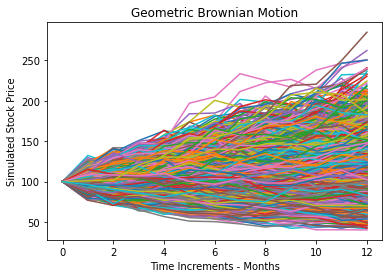

In [19]:
plt.plot(S.T);
plt.xlabel("Time Increments - Months")
plt.ylabel("Simulated Stock Price")
plt.title("Geometric Brownian Motion")

### Asian Opiton:
#### As closed form solution is not available, we will use monte-carlo simulation to price it.
In case of Black-scholes model we are concerned about the stock price at maturity  and then compare it with fixed strike but in case of Asian option(path dependent) we take average of all the values stock assumed and take average of it which becomes our final share price


In [4]:
## Fixed Strike Asian Call
S_avg = S.mean(axis = 1)           # per row we want one mean i.e. avg of 12 values stock takes that is why we take axis = 1
Fixed_Payoff = np.maximum(S_avg - K, 0)
Fixed_Payoff.head()

0     2.099767
1     0.000000
2     0.000000
3     8.260692
4    57.121603
dtype: float64

In [5]:
Fixed_Price  = Fixed_Payoff.mean()/np.exp(rf*T) # we are just bringing the payoff at maturity to the present value by discounting
# value comes out as less than plain vanilla price because terminal price will have more volatility than average of price path the stock evolves through
print("The price of the fixed strike Asian call option is:",Fixed_Price)

The price of the fixed strike Asian call option is: 6.607632548032895


In [6]:
## Floating Strike Asian Call
S_avg = S.mean(axis = 1)  
Float_Payoff = np.maximum(S.iloc[: , -1] - S_avg ,0) # average price becomes strike now and compare it with terminal price
Float_Payoff.head()

0    13.076355
1    12.974102
2     0.000000
3    11.878955
4    55.917475
dtype: float64

In [7]:
Float_Price  = Float_Payoff.mean() * np.exp(-rf*T)
print("The price of the floating strike Asian call option is:",Float_Price)

The price of the floating strike Asian call option is: 6.881136212858468


### Lookback Option:
The payoff depends on the optimal (maximum in our case) underlying asset's price occurring over the life of the option. The option allows the holder to "look back" over time to determine the payoff.

There exist two kinds of lookback options: with floating strike and with fixed strike.

In [11]:
# This gives maximum value of stock for every simulation
# per simulation we are extracting max and min of stock price that is we are looking columnwise(as per our data format)
S_max = S.max(axis = 1) 
S_min = S.min(axis = 1) 
S_max

0       115.176123
1       110.838800
2       100.182293
3       128.915837
4       213.039078
           ...    
9995    106.182393
9996    114.120794
9997    100.000000
9998    170.964102
9999    100.000000
Length: 10000, dtype: float64

In [20]:
# Fixed Strike
Payoff_fixed_lookback = np.maximum(S_max - K, 0)
Fixed_lookback_price = np.mean(Payoff_fixed_lookback)*np.exp(-rf*T)
print(f"Fixed strike lookback call price is {Fixed_lookback_price}")

# Floating Strike
Payoff_float_lookback = np.maximum(S.iloc[: , -1] - S_min, 0)
Float_lookback_price = np.mean(Payoff_float_lookback)*np.exp(-rf*T)
print(f"Floating strike lookback call price is {Float_lookback_price}")

Fixed strike lookback call price is 19.05297971882812
Floating strike lookback call price is 17.429066753191577
